In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.nn import functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
from prodigyopt import Prodigy
import torch.profiler

# 定义模型
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, categorical_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim_1)
        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.fc3 = nn.Linear(hidden_dim_2, categorical_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        logits = self.fc3(x)
        return logits

class Decoder(nn.Module):
    def __init__(self, categorical_dim, hidden_dim_1, hidden_dim_2, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(categorical_dim, hidden_dim_2)
        self.fc2 = nn.Linear(hidden_dim_2, hidden_dim_1)
        self.fc3 = nn.Linear(hidden_dim_1, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # 确保输出在[0,1]范围内
        return x

def gumbel_softmax(logits, temperature):
    gs = F.gumbel_softmax(logits, tau=temperature, hard=True, eps=1e-10, dim=-1)
    return gs


In [2]:
def train_and_plot(dataset_name, hidden_dim_1, hidden_dim_2, batch_size, epochs, initial_lr, temperature, final_temperature, beta):
    # 加载数据
    transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
    if dataset_name == "MNIST":
        dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    elif dataset_name == "FashionMNIST":
        dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
    elif dataset_name == "EMNIST":
        dataset = datasets.EMNIST('./data', train=True, download=True, transform=transform, split='balanced')
    dataset_img_size = dataset[0][0].shape[0]
    # get the number of classes
    classes = []
    for _, label in dataset:
        if label not in classes:
            classes.append(label)
    num_classes = len(classes)
    categorical_dim = num_classes
    input_dim = output_dim = dataset_img_size

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    annealing_rate = (temperature - final_temperature) / (epochs * len(dataloader))

    # 创建模型
    encoder = Encoder(input_dim, hidden_dim_1, hidden_dim_2, categorical_dim)
    decoder = Decoder(categorical_dim, hidden_dim_1, hidden_dim_2, output_dim)

    # Optimizer & Scheduler
    # optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=initial_lr)
    optimizer = Prodigy(list(encoder.parameters()) + list(decoder.parameters()), lr=initial_lr)
    scheduler = CosineAnnealingLR(optimizer, T_max=(len(dataloader) * epochs / 4), eta_min=1e-5)

    # initialize the loss lists
    recon_losses = []
    kl_losses = []
    total_losses = []
    lr_list = []
    temperature_list = []

    # initialize the progress bar
    progress_bar = tqdm(total=(len(dataloader) * epochs), desc="Training Progress")

    # train the model
    with torch.profiler.profile(
    schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=2),
    on_trace_ready=torch.profiler.tensorboard_trace_handler('./log'),
    record_shapes=True,
    with_stack=True
    ) as profiler:
        for epoch in range(epochs):
            for batch in dataloader:
                x, labels_in_batch = batch
                x = x.view(-1, input_dim)  # 确保x的形状
                logits = encoder(x)
                z = gumbel_softmax(logits, temperature)
                x_recon = decoder(z)

                # calculate the losses
                try:
                    recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum') / x.shape[0]
                except:
                    break
                log_softmax_logits = F.log_softmax(logits, dim=-1)
                uniform_distribution = torch.ones_like(log_softmax_logits) * (1.0 / categorical_dim)
                one_hot_labels = torch.zeros_like(log_softmax_logits).scatter_(1, labels_in_batch.unsqueeze(1), 1.0)
                kl_loss = F.kl_div(log_softmax_logits, one_hot_labels, reduction='sum') * beta
                loss = recon_loss + kl_loss

                # gradient descent & backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # log the losses
                recon_losses.append(recon_loss.item())
                kl_losses.append(kl_loss.item())
                total_losses.append(loss.item())
                lr_list.append(scheduler.get_last_lr()[0])
                temperature_list.append(temperature)

                # update the progress bar
                progress_bar.set_description(f'Epoch: {epoch+1}/{epochs} | Re.Loss: {recon_loss.item():.7f}, KL.Loss: {kl_loss.item():.7f} | Lr: {scheduler.get_last_lr()[0]:.7f} Temp: {temperature:.7f}', refresh=True)
                progress_bar.update(1)

                scheduler.step()  # update the learning rate
                temperature -= annealing_rate # update the temperature
                temperature = max(temperature, final_temperature)  # make sure the temperature is not lower than the minimum value

            # scheduler.step()  
            # temperature -= annealing_rate 
            # temperature = max(temperature, final_temperature)  
            profiler.step()  # Step after each epoch

    progress_bar.close()
    final_loss = total_losses[-1]

    # plot the losses curve
    plt.plot(recon_losses, label='Reconstruction Loss')
    plt.plot(kl_losses, label='KL Divergence Loss')
    plt.plot(total_losses, label='Total Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # plot the lr curve
    plt.plot(lr_list, label='lr')
    plt.show()

    # plot the temperature curve
    plt.plot(temperature_list, label='Temperature')
    plt.show()

    return dataset, encoder, decoder, final_loss


In [3]:
import random

def visualize_images(images, num_classes, title):
    fig, axes = plt.subplots(1, num_classes, figsize=(num_classes, 1))
    for i in range(num_classes):
        axes[i].imshow(images[i][0], cmap='gray')
        axes[i].axis('off')
    # plt.subplots_adjust(wspace=0.2, hspace=0.8)
    plt.suptitle(title)
    plt.show()

def sample_and_reconstruct(dataset, encoder, decoder, input_dim, num_classes, temperature):
    samples_per_class = 1
    original_images = [[] for _ in range(num_classes)]
    reconstructed_images = [[] for _ in range(num_classes)]
    selected_classes = [False] * num_classes
    
    with torch.no_grad():
        for x, y in random.sample(list(dataset), len(dataset)): # Shuffle dataset
            if all(selected_classes):
                break
            if selected_classes[y]:
                continue
            x = x.view(-1, input_dim)
            logits = encoder(x)
            z = gumbel_softmax(logits, temperature)
            x_recon = decoder(z)
            original_images[y].append(x.view(28, 28).numpy())
            reconstructed_images[y].append(x_recon.view(28, 28).numpy())
            selected_classes[y] = True

    visualize_images(original_images, num_classes, 'Original Images')
    visualize_images(reconstructed_images, num_classes, 'Reconstructed Images')



In [4]:
# Generate from latent vector
# categorical_dim = 10
# input_dim = 28 * 28
# temperature = 0.5

def generate_from_latent(dataset, encoder, decoder, categorical_dim, temperature):
    # init
    latent_sums = torch.zeros(categorical_dim, categorical_dim)
    class_counts = torch.zeros(categorical_dim, dtype=torch.int)

    # calculate the sum of latent vectors for each class
    with torch.no_grad():
        for img, label in dataset:
            img = img.view(-1, input_dim)
            logits = encoder(img)
            z = gumbel_softmax(logits, temperature).squeeze()
            latent_sums[label] += z
            class_counts[label] += 1

    # calculate the average latent vector for each class
    avg_latent_vector = latent_sums / class_counts[:, None]

    fig, axes = plt.subplots(1, categorical_dim, figsize=(categorical_dim, 1))

    # plot for each class
    for i in range(categorical_dim):
        generated_img = decoder(avg_latent_vector[i])
        generated_img = generated_img.view(28, 28).detach().cpu().numpy()  # 转换为numpy数组
        ax = axes[i]
        ax.imshow(generated_img, cmap='gray')
        ax.set_title(f'Class {i}')
        ax.axis('off')

    # apply transformations to EMNIST images
    if dataset_name == 'EMNIST':
        from scipy.ndimage import rotate
        plt.close(fig)  # 关闭原始图像
        rows = 5
        cols = 10
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
        # fig.subplots_adjust(hspace=0.2, wspace=0.2)  # 调整子图间的间距
        fig.suptitle('Generated EMNIST Images (rotated and flipped)')

        for i in range(categorical_dim):
            row = i // cols
            col = i % cols
            generated_img = decoder(avg_latent_vector[i])
            generated_img = generated_img.view(28, 28).detach().cpu().numpy()
            generated_img = rotate(generated_img, -90)  # 逆时针旋转90度
            generated_img = np.fliplr(generated_img)  # 水平镜像
            ax = axes[row, col]
            ax.imshow(generated_img, cmap='gray')
            ax.set_title(f'Class {i}')
            ax.axis('off')
        # 隐藏多余的子图
        for i in range(categorical_dim, rows * cols):
            row = i // cols
            col = i % cols
            axes[row, col].axis('off')
        fig.tight_layout()

    plt.show()


In [5]:
from sklearn.manifold import TSNE
import numpy as np

def visualize_latent(dataset_name, encoder, num_classes=10, temperature=1.0):
    # init
    latent_vectors = torch.empty(0, categorical_dim)
    Y = torch.empty(0, dtype=torch.long)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # send dataset to encoder
    with torch.no_grad():
        for x, y in dataloader:
            x = x.view(-1, input_dim)
            logits = encoder(x)
            z = gumbel_softmax(logits, temperature)
            latent_vectors = torch.cat([latent_vectors, z])
            Y = torch.cat([Y, y])

    # convert latent vectors to numpy arrays
    latent_vectors = latent_vectors.cpu().numpy()
    Y = Y.cpu().numpy()

    # run t-SNE on latent vectors to get 2D embedding
    tsne = TSNE(n_components=2)
    latent_vectors_2d = tsne.fit_transform(latent_vectors)

    # plot 2D embedding
    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(latent_vectors_2d[:, 0], latent_vectors_2d[:, 1], c=Y, cmap='tab10')
    if dataset_name == 'EMNIST':
        scatter = plt.scatter(latent_vectors_2d[:, 0], latent_vectors_2d[:, 1], c=Y, cmap='tab20')
    plt.colorbar(scatter, label='Class Labels')
    for i in range(num_classes):
        centroid = np.mean(latent_vectors_2d[Y == i], axis=0)
        plt.text(centroid[0], centroid[1], str(i), color='black', fontsize=12, fontweight='bold', ha='center', va='center')
    plt.show()

    # cm
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    # find the most likely label for each test input
    predicted_labels = latent_vectors.argmax(axis=1)

    # calculate the confusion matrix
    cm = confusion_matrix(Y, predicted_labels)

    # plot the confusion matrix
    plt.figure(figsize=(10, 8))
    if dataset_name == 'EMNIST':
        plt.figure(figsize=(50, 40))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # calculate accuracy
    from sklearn.metrics import adjusted_rand_score
    rand_index = adjusted_rand_score(Y, predicted_labels)
    print("Rand index: ", rand_index)


[I 2023-08-05 02:55:56,136] A new study created in memory with name: no-name-bff55822-b516-4171-9d1f-d7d068ea0a32
Epoch: 2/43 | Re.Loss: 543.0051270, KL.Loss: 35599.7773438 | Lr: 0.0004553 Temp: 1.0567344:   5%|▍         | 185/3999 [00:22<07:32,  8.43it/s]STAGE:2023-08-05 02:56:21 29615:1610375 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
Epoch: 5/43 | Re.Loss: 543.0347900, KL.Loss: 35661.7617188 | Lr: 0.0002798 Temp: 1.0132862:  12%|█▏        | 464/3999 [01:05<08:59,  6.56it/s]STAGE:2023-08-05 02:58:04 29615:1610375 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-08-05 02:58:08 29615:1610375 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
Epoch: 7/43 | Re.Loss: 543.0181885, KL.Loss: 35616.9062500 | Lr: 0.0001423 Temp: 0.9843208:  16%|█▋        | 650/3999 [16:32<06:38,  8.40it/s]     STAGE:2023-08-05 03:12:31 29615:1610375 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
Epoch: 10/43 | Re.Loss: 542.9961548, KL.

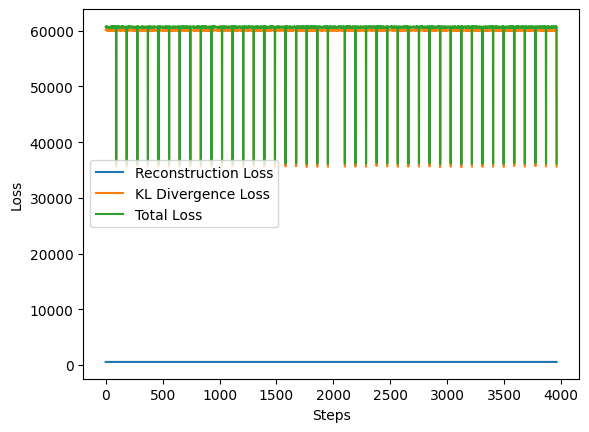

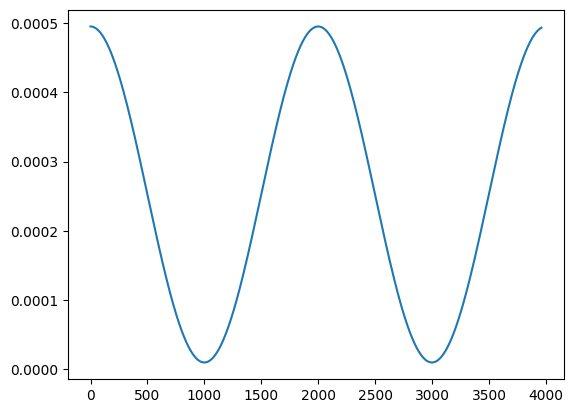

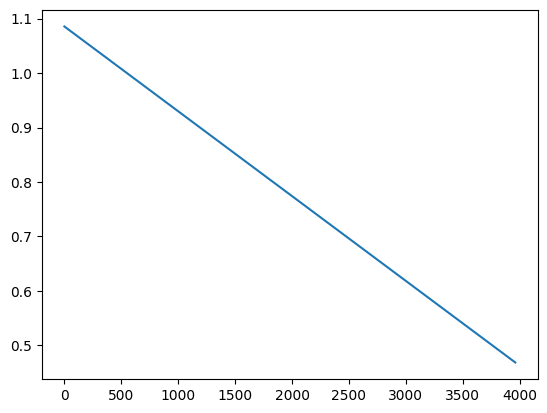

[I 2023-08-05 03:33:26,063] Trial 0 finished with value: 36171.44140625 and parameters: {'hidden_dim_1': 502, 'hidden_dim_2': 109, 'batch_size': 648, 'epochs': 43, 'initial_lr': 0.0004951208836756914, 'temperature': 1.0855440479832779, 'final_temperature': 0.4627873928848787, 'beta': 40.249269078056706}. Best is trial 0 with value: 36171.44140625.


Finished trail 0/100 | Final loss: 36171.44140625


Epoch: 2/102 | Re.Loss: 543.5971069, KL.Loss: 79.8703003 | Lr: 0.0007014 Temp: 1.1111818:   2%|▏         | 937/47838 [00:26<22:15, 35.11it/s] STAGE:2023-08-05 03:33:55 29615:1610375 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
Epoch: 5/102 | Re.Loss: 543.5840454, KL.Loss: 79.7401581 | Lr: 0.0006475 Temp: 1.0913403:   5%|▍         | 2345/47838 [09:26<29:40, 25.56it/s] STAGE:2023-08-05 03:36:05 29615:1610375 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-08-05 03:36:10 29615:1610375 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
Epoch: 7/102 | Re.Loss: 543.5214233, KL.Loss: 80.0021286 | Lr: 0.0005894 Temp: 1.0781126:   7%|▋         | 3282/47838 [24:26<21:16, 34.91it/s]       STAGE:2023-08-05 03:57:55 29615:1610375 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
Epoch: 10/102 | Re.Loss: 543.5572510, KL.Loss: 79.8887939 | Lr: 0.0004777 Temp: 1.0582710:  10%|▉         | 4689/47838 [25:20<27:21, 26.29it/s] STAGE:2

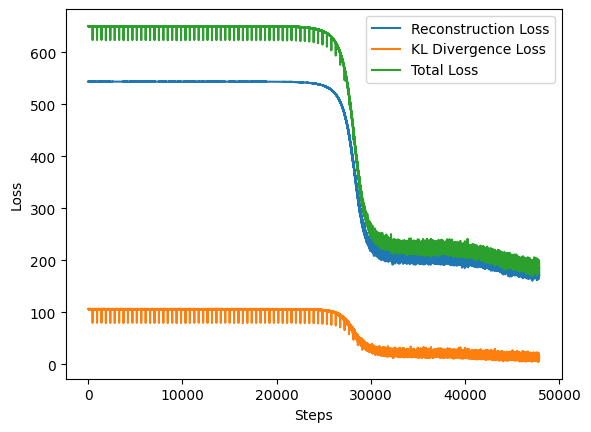

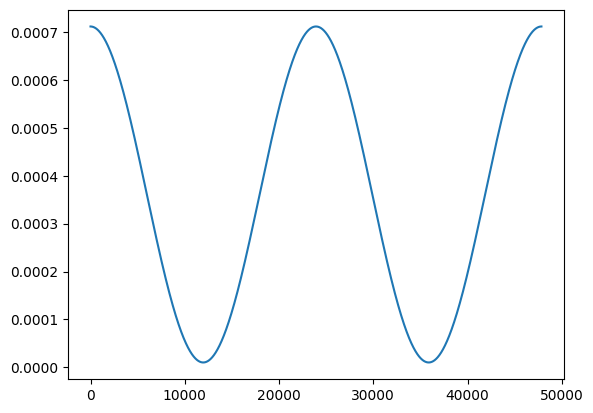

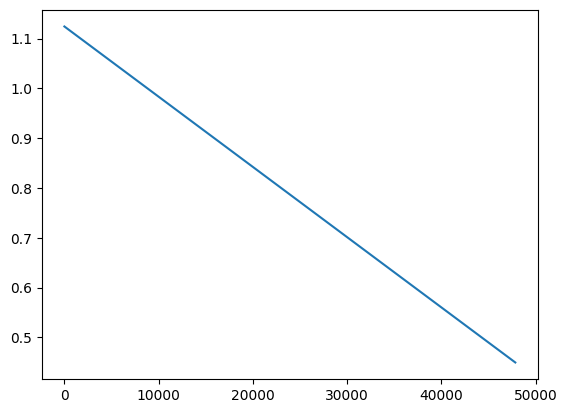

[I 2023-08-05 04:37:37,428] Trial 1 finished with value: 184.8036346435547 and parameters: {'hidden_dim_1': 460, 'hidden_dim_2': 103, 'batch_size': 128, 'epochs': 102, 'initial_lr': 0.0007119633552633598, 'temperature': 1.1243954350684175, 'final_temperature': 0.44978251912591605, 'beta': 0.36021916177499097}. Best is trial 1 with value: 184.8036346435547.


Finished trail 1/100 | Final loss: 184.8036346435547


Epoch: 2/45 | Re.Loss: 539.0116577, KL.Loss: 11679.2871094 | Lr: 0.0060459 Temp: 1.1816961:   4%|▍         | 403/9090 [00:21<07:42, 18.80it/s]STAGE:2023-08-05 04:38:02 29615:1610375 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
Epoch: 5/45 | Re.Loss: 180.3764191, KL.Loss: 1410.6842041 | Lr: 0.0038462 Temp: 1.1094120:  11%|█         | 1009/9090 [01:10<10:33, 12.75it/s]STAGE:2023-08-05 04:40:01 29615:1610375 ActivityProfilerController.cpp:317] Completed Stage: Collection
Epoch: 5/45 | Re.Loss: 180.3764191, KL.Loss: 1410.6842041 | Lr: 0.0038462 Temp: 1.1094120:  11%|█         | 1010/9090 [08:04<10:33, 12.75it/s]STAGE:2023-08-05 04:40:05 29615:1610375 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
Epoch: 7/45 | Re.Loss: 170.9977570, KL.Loss: 1309.3607178 | Lr: 0.0020560 Temp: 1.0612226:  16%|█▌        | 1413/9090 [22:04<06:40, 19.16it/s]     STAGE:2023-08-05 04:59:45 29615:1610375 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
Epoch: 10/45

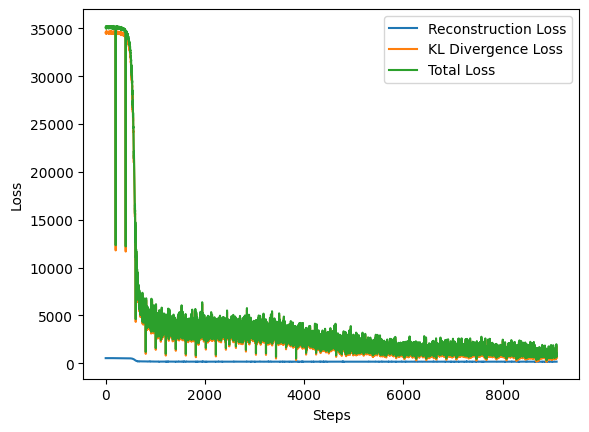

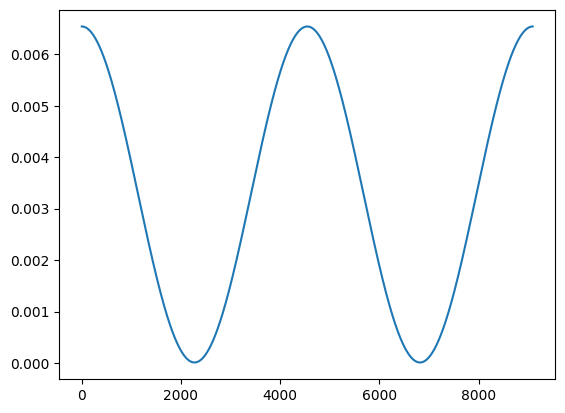

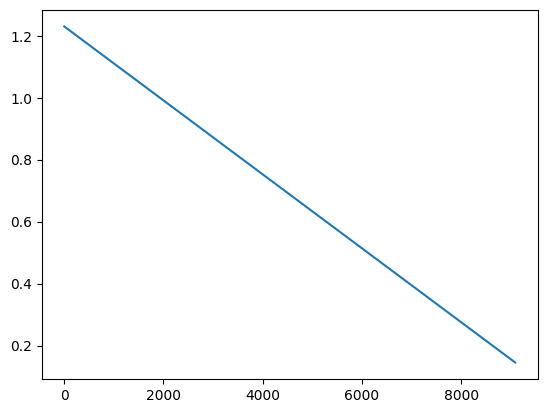

[I 2023-08-05 05:22:44,452] Trial 2 finished with value: 876.4163818359375 and parameters: {'hidden_dim_1': 418, 'hidden_dim_2': 98, 'batch_size': 298, 'epochs': 45, 'initial_lr': 0.006539568585445502, 'temperature': 1.2297661949978684, 'final_temperature': 0.14550479467013744, 'beta': 50.278255755650264}. Best is trial 1 with value: 184.8036346435547.


Finished trail 2/100 | Final loss: 876.4163818359375


Epoch: 2/89 | Re.Loss: 544.7492065, KL.Loss: 11039.3720703 | Lr: 0.0023129 Temp: 1.1648998:   2%|▏         | 290/12905 [00:13<09:29, 22.14it/s]STAGE:2023-08-05 05:23:00 29615:1610375 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
Epoch: 5/89 | Re.Loss: 544.6612549, KL.Loss: 11067.3603516 | Lr: 0.0020791 Temp: 1.1568873:   6%|▌         | 725/12905 [00:47<15:02, 13.50it/s]STAGE:2023-08-05 05:24:44 29615:1610375 ActivityProfilerController.cpp:317] Completed Stage: Collection
Epoch: 5/89 | Re.Loss: 544.6612549, KL.Loss: 11067.3603516 | Lr: 0.0020791 Temp: 1.1568873:   6%|▌         | 725/12905 [08:18<15:02, 13.50it/s]STAGE:2023-08-05 05:24:48 29615:1610375 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
Epoch: 7/89 | Re.Loss: 544.5887451, KL.Loss: 11049.3867188 | Lr: 0.0018316 Temp: 1.1515457:   8%|▊         | 1014/12905 [21:44<08:46, 22.60it/s]    STAGE:2023-08-05 05:44:32 29615:1610375 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
Epoch: 1

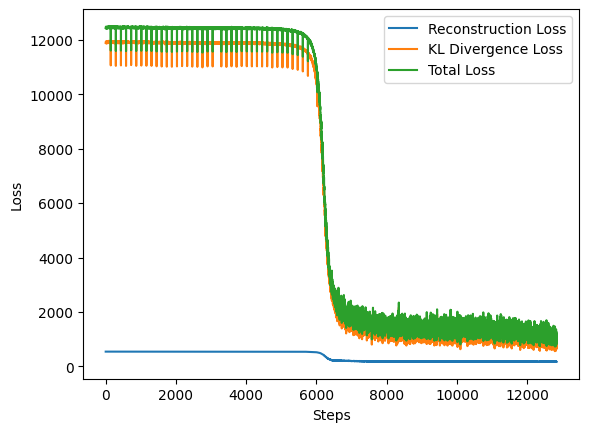

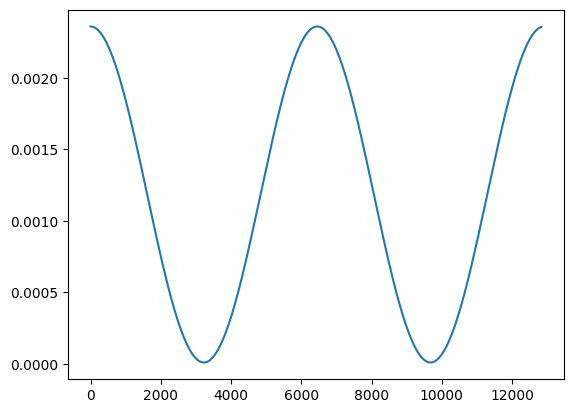

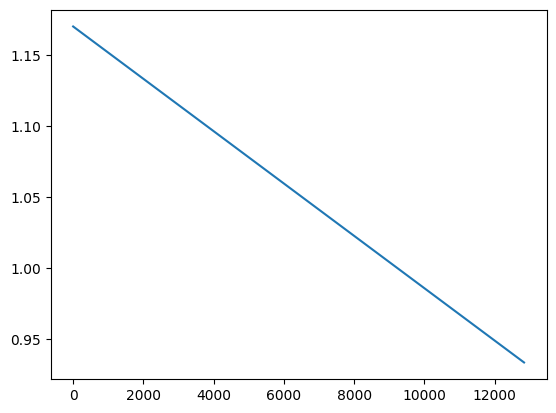

[I 2023-08-05 06:08:56,680] Trial 3 finished with value: 1247.208740234375 and parameters: {'hidden_dim_1': 153, 'hidden_dim_2': 104, 'batch_size': 414, 'epochs': 89, 'initial_lr': 0.002359107195826951, 'temperature': 1.1702229507648005, 'final_temperature': 0.932521389267935, 'beta': 12.474177318237606}. Best is trial 1 with value: 184.8036346435547.


Finished trail 3/100 | Final loss: 1247.208740234375


Epoch: 2/67 | Re.Loss: 179.2185364, KL.Loss: 116.4204941 | Lr: 0.0055228 Temp: 1.0986501:   3%|▎         | 1950/69345 [00:29<16:41, 67.29it/s] STAGE:2023-08-05 06:09:28 29615:1610375 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
Epoch: 5/67 | Re.Loss: 176.7283020, KL.Loss: 61.8170242 | Lr: 0.0045863 Temp: 1.0888775:   7%|▋         | 5055/69345 [01:34<22:28, 47.69it/s]  STAGE:2023-08-05 06:12:05 29615:1610375 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-08-05 06:12:10 29615:1610375 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
Epoch: 7/67 | Re.Loss: 166.8685150, KL.Loss: 125.9964371 | Lr: 0.0036393 Temp: 1.0823624:  10%|█         | 7126/69345 [33:50<15:17, 67.78it/s]      STAGE:2023-08-05 06:42:49 29615:1610375 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
Epoch: 10/67 | Re.Loss: 174.6474915, KL.Loss: 30.3669147 | Lr: 0.0020599 Temp: 1.0725897:  15%|█▍        | 10231/69345 [46:13<19:12, 51.29it/s] STAGE:2

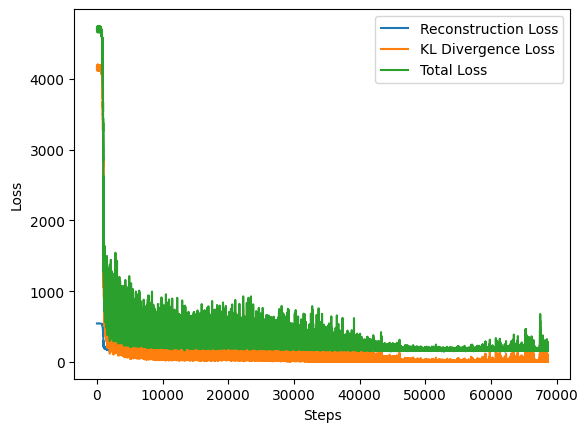

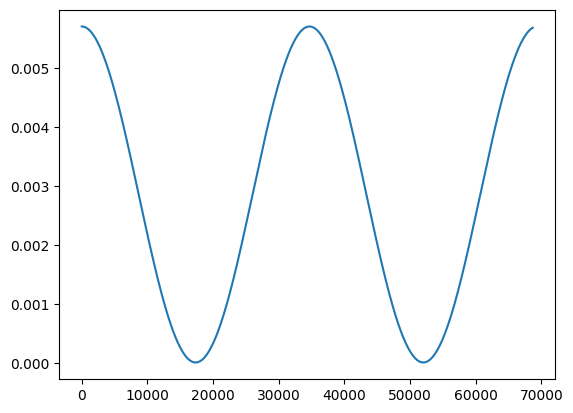

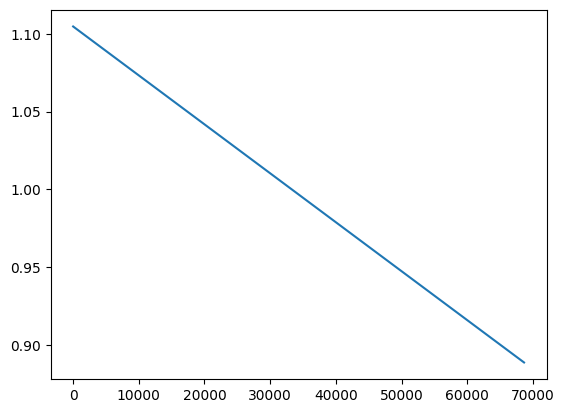

[I 2023-08-05 07:28:10,133] Trial 4 finished with value: 173.02938842773438 and parameters: {'hidden_dim_1': 397, 'hidden_dim_2': 49, 'batch_size': 58, 'epochs': 67, 'initial_lr': 0.005698505034935365, 'temperature': 1.1047874997024723, 'final_temperature': 0.8865320208211237, 'beta': 31.096617310835946}. Best is trial 4 with value: 173.02938842773438.


Finished trail 4/100 | Final loss: 173.02938842773438


Epoch: 2/37 | Re.Loss: 542.5003052, KL.Loss: 1121.0158691 | Lr: 0.0005375 Temp: 1.8508953:   5%|▌         | 1819/33670 [00:31<09:12, 57.63it/s] STAGE:2023-08-05 07:28:44 29615:1610375 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
Epoch: 5/37 | Re.Loss: 542.5474854, KL.Loss: 1119.0220947 | Lr: 0.0002691 Temp: 1.7401179:  14%|█▎        | 4549/33670 [01:41<12:00, 40.44it/s] STAGE:2023-08-05 07:31:26 29615:1610375 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-08-05 07:31:31 29615:1610375 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
Epoch: 7/37 | Re.Loss: 542.9685669, KL.Loss: 1124.9694824 | Lr: 0.0000926 Temp: 1.6662663:  19%|█▉        | 6369/33670 [35:29<08:01, 56.70it/s]      STAGE:2023-08-05 08:03:43 29615:1610375 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
Epoch: 10/37 | Re.Loss: 542.4570923, KL.Loss: 1122.6520996 | Lr: 0.0000195 Temp: 1.5554889:  27%|██▋       | 9100/33670 [47:19<09:26, 43.39it/s] STA

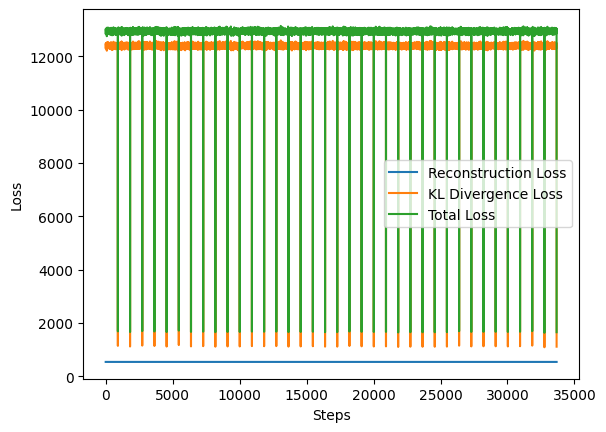

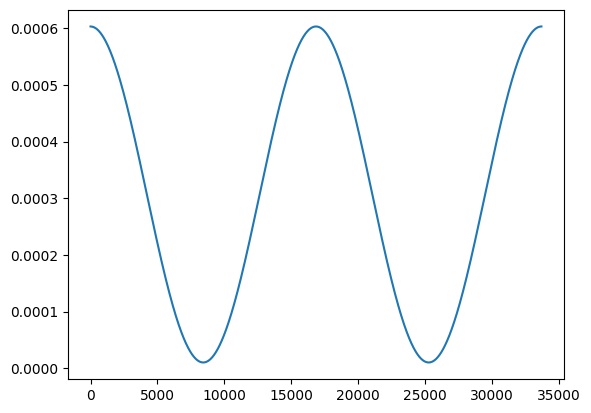

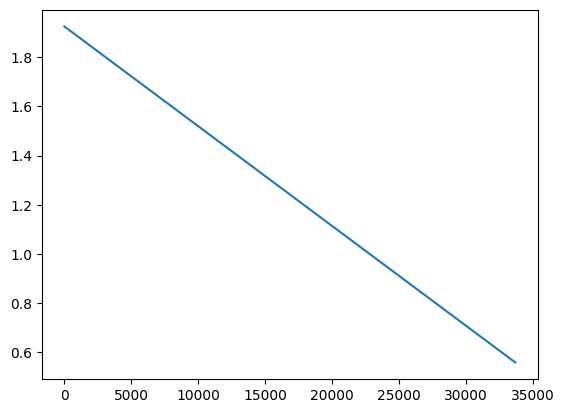

[I 2023-08-05 08:41:10,656] Trial 5 finished with value: 1657.05126953125 and parameters: {'hidden_dim_1': 466, 'hidden_dim_2': 68, 'batch_size': 66, 'epochs': 37, 'initial_lr': 0.0006032751868814325, 'temperature': 1.924706378066747, 'final_temperature': 0.5584516002101768, 'beta': 81.3704469292423}. Best is trial 4 with value: 173.02938842773438.


Finished trail 5/100 | Final loss: 1657.05126953125


Epoch: 2/80 | Re.Loss: 543.3875122, KL.Loss: 32079.1855469 | Lr: 0.0005295 Temp: 0.8882104:   2%|▎         | 230/9200 [00:15<09:37, 15.53it/s]STAGE:2023-08-05 08:41:28 29615:1610375 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
Epoch: 5/80 | Re.Loss: 543.3236694, KL.Loss: 31984.2285156 | Lr: 0.0004647 Temp: 0.8659855:   6%|▌         | 574/9200 [00:55<16:03,  8.95it/s]STAGE:2023-08-05 08:43:20 29615:1610375 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-08-05 08:43:24 29615:1610375 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
Epoch: 7/80 | Re.Loss: 543.3831787, KL.Loss: 31956.4082031 | Lr: 0.0003974 Temp: 0.8511689:   9%|▉         | 805/9200 [25:07<09:05, 15.38it/s]     STAGE:2023-08-05 09:06:21 29615:1610375 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
Epoch: 10/80 | Re.Loss: 543.3433838, KL.Loss: 32036.0488281 | Lr: 0.0002766 Temp: 0.8289440:  12%|█▏        | 1149/9200 [25:41<12:38, 10.61it/s]STAGE:2023

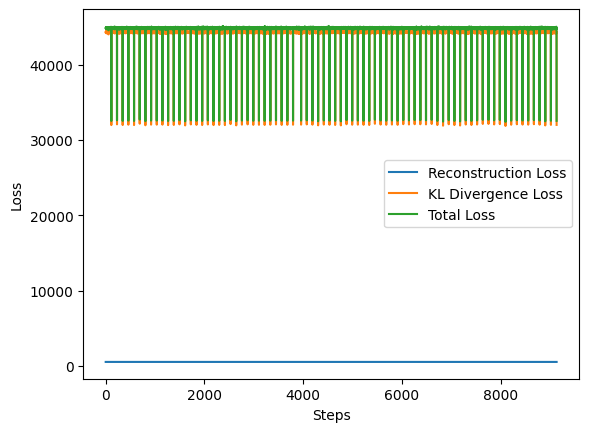

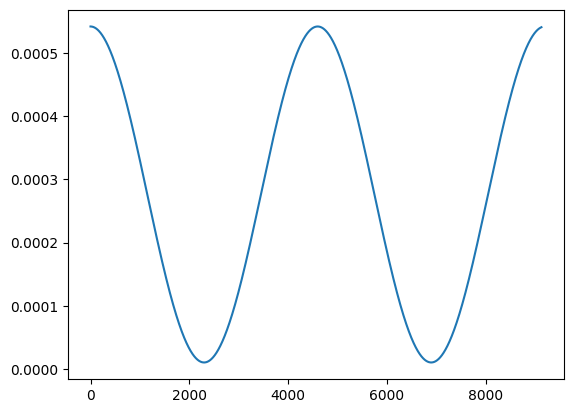

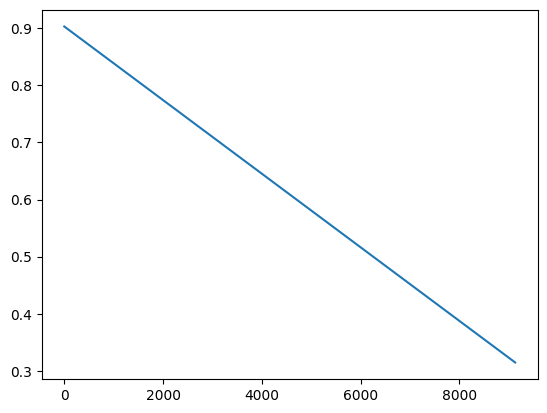

[I 2023-08-05 09:33:10,970] Trial 6 finished with value: 32548.744140625 and parameters: {'hidden_dim_1': 257, 'hidden_dim_2': 80, 'batch_size': 523, 'epochs': 80, 'initial_lr': 0.0005424120192921033, 'temperature': 0.902962638522405, 'final_temperature': 0.3102979093403931, 'beta': 36.664441382635985}. Best is trial 4 with value: 173.02938842773438.


Finished trail 6/100 | Final loss: 32548.744140625


Epoch: 2/85 | Re.Loss: 544.3517456, KL.Loss: 54795.0781250 | Lr: 0.0001610 Temp: 0.8493298:   2%|▏         | 196/8330 [00:12<08:23, 16.16it/s]STAGE:2023-08-05 09:33:26 29615:1610375 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
Epoch: 5/85 | Re.Loss: 544.3017578, KL.Loss: 54914.6289062 | Lr: 0.0001442 Temp: 0.8368764:   6%|▌         | 489/8330 [00:46<15:03,  8.68it/s]STAGE:2023-08-05 09:35:10 29615:1610375 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-08-05 09:35:14 29615:1610375 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
Epoch: 7/85 | Re.Loss: 544.3706055, KL.Loss: 54803.1054688 | Lr: 0.0001266 Temp: 0.8285742:   8%|▊         | 686/8330 [24:18<07:57, 16.02it/s]     STAGE:2023-08-05 09:57:32 29615:1610375 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
Epoch: 10/85 | Re.Loss: 544.2572021, KL.Loss: 54694.9609375 | Lr: 0.0000944 Temp: 0.8161208:  12%|█▏        | 980/8330 [24:49<11:33, 10.60it/s]STAGE:2023-

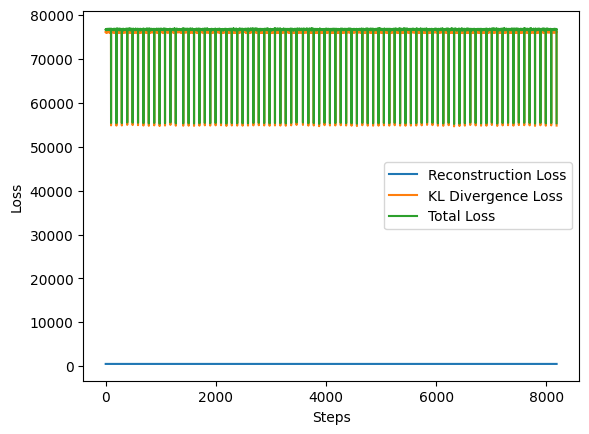

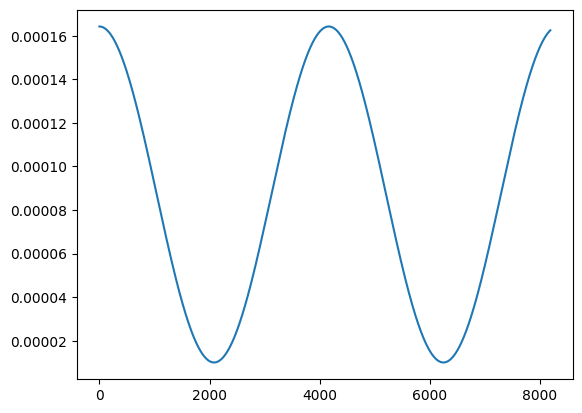

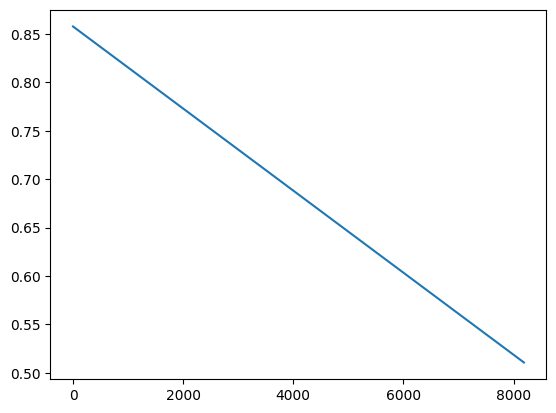

[I 2023-08-05 10:22:03,613] Trial 7 finished with value: 55342.6328125 and parameters: {'hidden_dim_1': 175, 'hidden_dim_2': 40, 'batch_size': 614, 'epochs': 85, 'initial_lr': 0.00016429298506079047, 'temperature': 0.8575896364925677, 'final_temperature': 0.504744544061529, 'beta': 53.72069766048429}. Best is trial 4 with value: 173.02938842773438.


Finished trail 7/100 | Final loss: 55342.6328125


Epoch: 2/80 | Re.Loss: 544.1696167, KL.Loss: 76556.1562500 | Lr: 0.0026693 Temp: 0.9899384:   2%|▎         | 164/6560 [00:13<08:25, 12.66it/s]STAGE:2023-08-05 10:22:19 29615:1610375 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
Epoch: 5/80 | Re.Loss: 544.0856934, KL.Loss: 76560.5937500 | Lr: 0.0023379 Temp: 0.9727383:   6%|▋         | 410/6560 [00:46<13:24,  7.64it/s]STAGE:2023-08-05 10:24:00 29615:1610375 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-08-05 10:24:04 29615:1610375 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
Epoch: 7/80 | Re.Loss: 544.0793457, KL.Loss: 76423.4218750 | Lr: 0.0019935 Temp: 0.9612715:   9%|▉         | 574/6560 [21:47<07:52, 12.68it/s]     STAGE:2023-08-05 10:43:53 29615:1610375 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
Epoch: 10/80 | Re.Loss: 544.0899048, KL.Loss: 76435.2343750 | Lr: 0.0013752 Temp: 0.9440714:  12%|█▎        | 820/6560 [22:18<11:20,  8.43it/s]STAGE:2023-

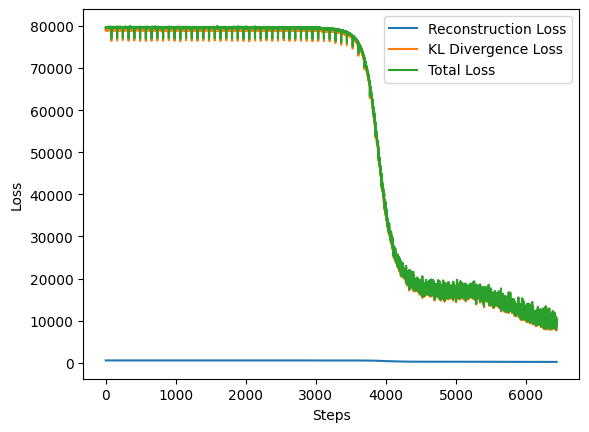

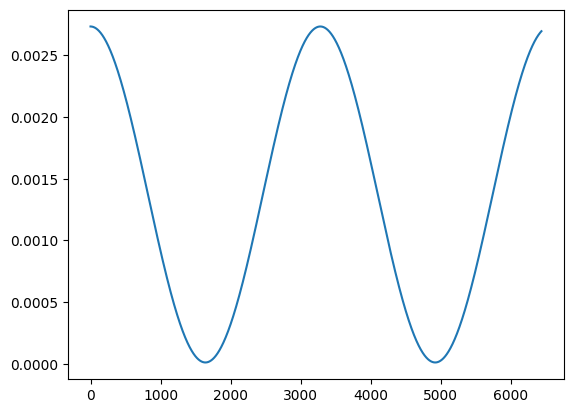

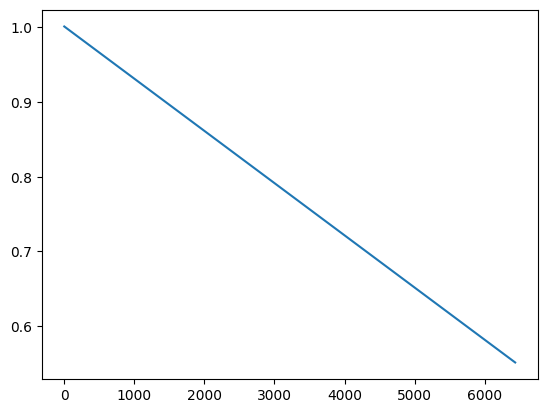

[I 2023-08-05 11:08:50,527] Trial 8 finished with value: 9002.7890625 and parameters: {'hidden_dim_1': 194, 'hidden_dim_2': 66, 'batch_size': 732, 'epochs': 80, 'initial_lr': 0.0027351511108959295, 'temperature': 1.001335233658181, 'final_temperature': 0.5426649969091076, 'beta': 46.73676212588678}. Best is trial 4 with value: 173.02938842773438.


Finished trail 8/100 | Final loss: 9002.7890625


Epoch: 2/43 | Re.Loss: 543.7424927, KL.Loss: 40157.4179688 | Lr: 0.0075871 Temp: 1.2137046:   5%|▍         | 131/2838 [00:16<05:35,  8.08it/s]STAGE:2023-08-05 11:09:09 29615:1610375 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
Epoch: 5/43 | Re.Loss: 538.7789917, KL.Loss: 39423.4648438 | Lr: 0.0046054 Temp: 1.1528330:  12%|█▏        | 330/2838 [00:55<07:14,  5.77it/s]STAGE:2023-08-05 11:10:59 29615:1610375 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-08-05 11:11:03 29615:1610375 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
Epoch: 7/43 | Re.Loss: 521.3338623, KL.Loss: 36479.6367188 | Lr: 0.0022657 Temp: 1.1122520:  16%|█▌        | 461/2838 [21:18<04:50,  8.17it/s]     STAGE:2023-08-05 11:30:11 29615:1610375 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
Epoch: 10/43 | Re.Loss: 502.0287476, KL.Loss: 33018.5859375 | Lr: 0.0001127 Temp: 1.0513804:  23%|██▎       | 660/2838 [21:53<05:33,  6.53it/s]STAGE:2023-

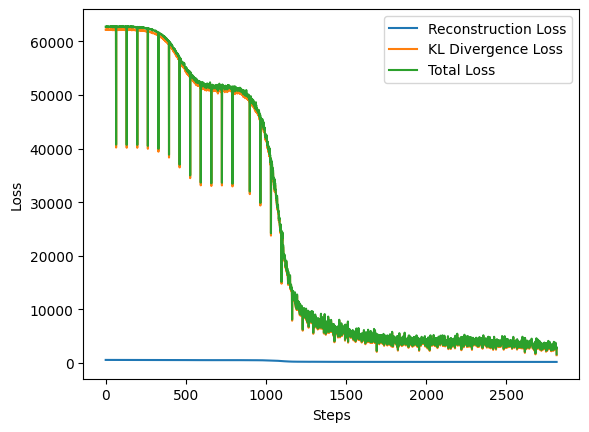

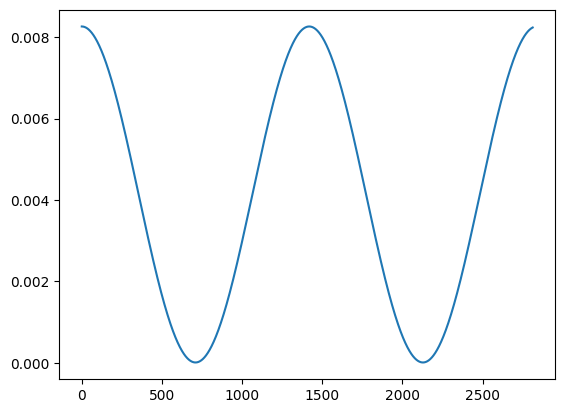

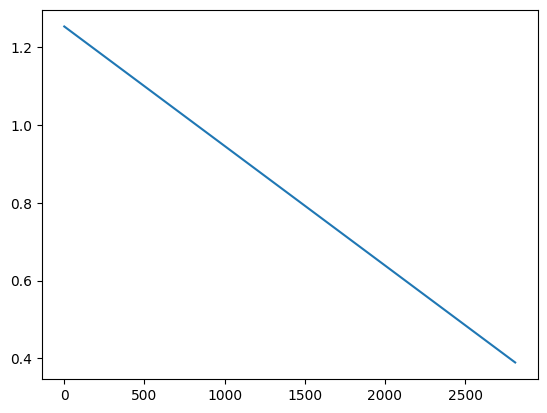

[I 2023-08-05 11:51:27,670] Trial 9 finished with value: 1603.9234619140625 and parameters: {'hidden_dim_1': 336, 'hidden_dim_2': 69, 'batch_size': 914, 'epochs': 43, 'initial_lr': 0.008262023219890943, 'temperature': 1.2539781703749164, 'final_temperature': 0.38148590931721893, 'beta': 29.56186635773531}. Best is trial 4 with value: 173.02938842773438.


Finished trail 9/100 | Final loss: 1603.9234619140625


Epoch: 2/122 | Re.Loss: 205.1169434, KL.Loss: 8021.2368164 | Lr: 0.0096117 Temp: 0.9802455:   2%|▏         | 420/25620 [00:17<17:28, 24.02it/s] STAGE:2023-08-05 11:51:48 29615:1610375 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
Epoch: 5/122 | Re.Loss: 170.3683929, KL.Loss: 2662.1345215 | Lr: 0.0090856 Temp: 0.9888588:   4%|▍         | 1050/25620 [00:58<25:59, 15.75it/s]STAGE:2023-08-05 11:53:39 29615:1610375 ActivityProfilerController.cpp:317] Completed Stage: Collection
Epoch: 5/122 | Re.Loss: 170.3683929, KL.Loss: 2662.1345215 | Lr: 0.0090856 Temp: 0.9888588:   4%|▍         | 1050/25620 [07:53<25:59, 15.75it/s]STAGE:2023-08-05 11:53:45 29615:1610375 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
Epoch: 7/122 | Re.Loss: 168.6956635, KL.Loss: 1867.1403809 | Lr: 0.0085438 Temp: 0.9942866:   6%|▌         | 1446/25620 [23:50<16:54, 23.84it/s]      STAGE:2023-08-05 12:15:21 29615:1610375 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
Epo

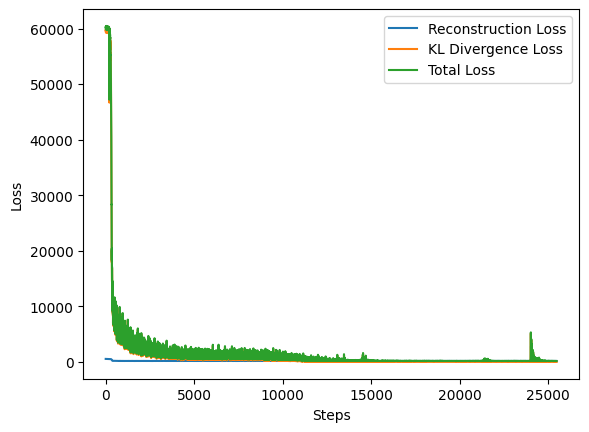

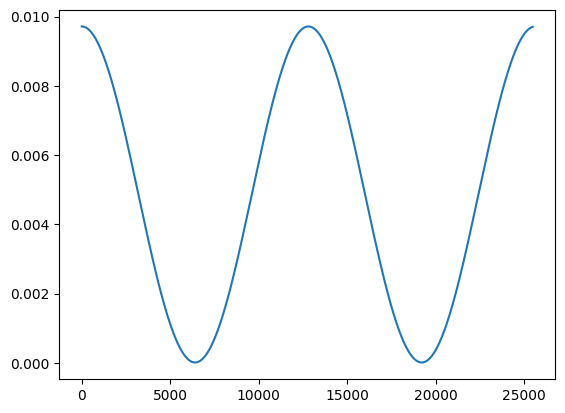

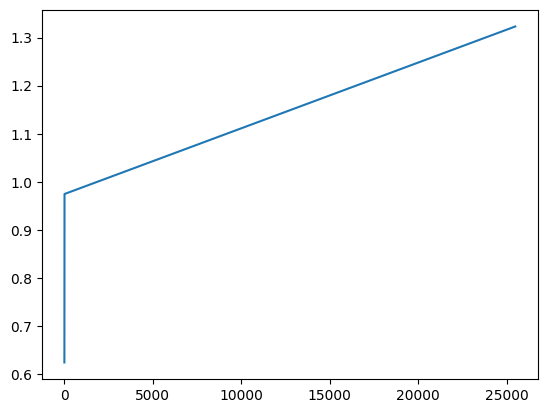

[I 2023-08-05 12:51:42,003] Trial 10 finished with value: 170.5261688232422 and parameters: {'hidden_dim_1': 341, 'hidden_dim_2': 36, 'batch_size': 286, 'epochs': 122, 'initial_lr': 0.00971383353365805, 'temperature': 0.6242548171813347, 'final_temperature': 0.9745305954152271, 'beta': 90.16606286136232}. Best is trial 10 with value: 170.5261688232422.


Finished trail 10/100 | Final loss: 170.5261688232422


Epoch: 2/124 | Re.Loss: 196.6063232, KL.Loss: 534.5949097 | Lr: 0.0098032 Temp: 0.9984791:   2%|▏         | 477/29636 [00:18<18:42, 25.98it/s]  STAGE:2023-08-05 12:52:03 29615:1610375 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
Epoch: 5/124 | Re.Loss: 165.8919220, KL.Loss: 58.4843216 | Lr: 0.0092834 Temp: 1.0097675:   4%|▍         | 1194/29636 [01:03<28:57, 16.37it/s]  STAGE:2023-08-05 12:54:01 29615:1610375 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-08-05 12:54:05 29615:1610375 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
Epoch: 7/124 | Re.Loss: 173.7664795, KL.Loss: 422.4057007 | Lr: 0.0087119 Temp: 1.0172930:   6%|▌         | 1672/29636 [24:59<18:30, 25.19it/s]       STAGE:2023-08-05 13:16:44 29615:1610375 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
Epoch: 10/124 | Re.Loss: 177.2283325, KL.Loss: 481.2786865 | Lr: 0.0075756 Temp: 1.0285813:   8%|▊         | 2389/29636 [25:39<24:20, 18.65it/s] ST

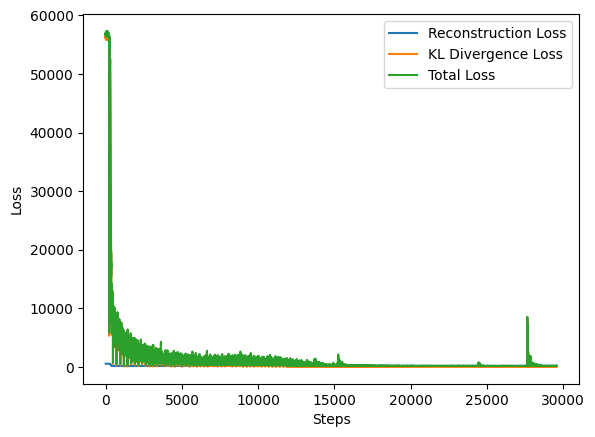

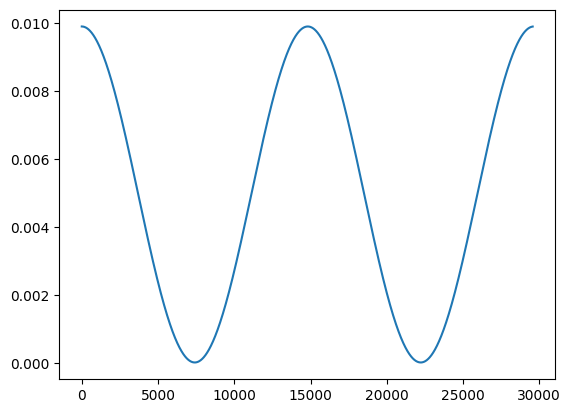

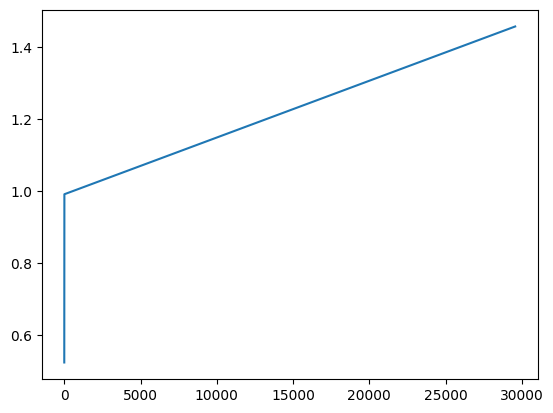

[I 2023-08-05 13:52:55,561] Trial 11 finished with value: 181.29788208007812 and parameters: {'hidden_dim_1': 353, 'hidden_dim_2': 34, 'batch_size': 252, 'epochs': 124, 'initial_lr': 0.009904000518606924, 'temperature': 0.5244008124368355, 'final_temperature': 0.9909850580701721, 'beta': 96.68978673084396}. Best is trial 10 with value: 170.5261688232422.


Finished trail 11/100 | Final loss: 181.29788208007812


Epoch: 2/62 | Re.Loss: 166.0577087, KL.Loss: 229.7692871 | Lr: 0.0036800 Temp: 0.8414953:   3%|▎         | 3430/106330 [00:37<18:59, 90.29it/s] STAGE:2023-08-05 13:53:36 29615:1610375 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
Epoch: 5/62 | Re.Loss: 172.0924377, KL.Loss: 94.7055664 | Lr: 0.0029342 Temp: 0.8566290:   8%|▊         | 8575/106330 [18:54<23:19, 69.85it/s]  STAGE:2023-08-05 13:56:45 29615:1610375 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-08-05 13:56:52 29615:1610375 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
Epoch: 7/62 | Re.Loss: 197.2495728, KL.Loss: 62.9855042 | Lr: 0.0022123 Temp: 0.8667181:  11%|█▏        | 12004/106330 [50:33<17:24, 90.32it/s]       STAGE:2023-08-05 14:43:32 29615:1610375 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
Epoch: 10/62 | Re.Loss: 182.4798584, KL.Loss: 16.0785427 | Lr: 0.0010804 Temp: 0.8818518:  16%|█▌        | 17150/106330 [1:08:47<21:55, 67.80it/s]S

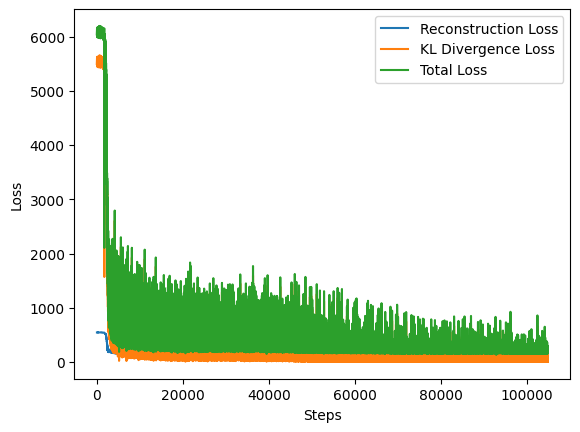

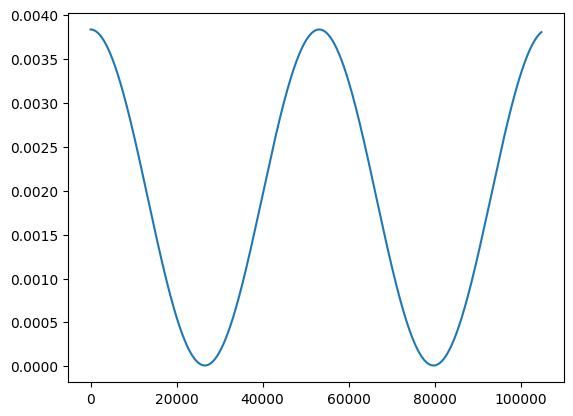

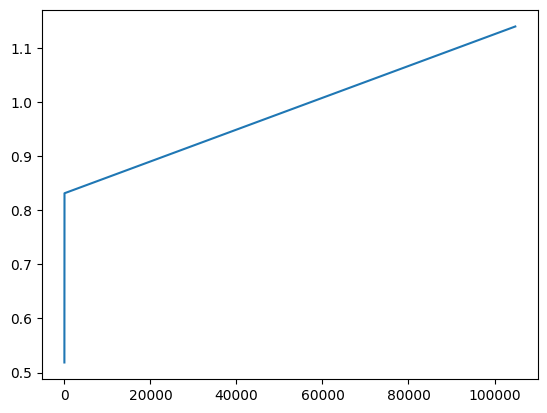

[I 2023-08-05 15:46:18,470] Trial 12 finished with value: 197.83306884765625 and parameters: {'hidden_dim_1': 389, 'hidden_dim_2': 44, 'batch_size': 35, 'epochs': 62, 'initial_lr': 0.0038348761453702003, 'temperature': 0.5186488213889388, 'final_temperature': 0.8314120118497567, 'beta': 68.61076772103397}. Best is trial 10 with value: 170.5261688232422.


Finished trail 12/100 | Final loss: 197.83306884765625


Epoch: 2/128 | Re.Loss: 544.1259155, KL.Loss: 50033.1484375 | Lr: 0.0044564 Temp: 0.7909702:   2%|▏         | 495/31744 [00:17<18:05, 28.78it/s]STAGE:2023-08-05 15:46:39 29615:1610375 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
Epoch: 5/128 | Re.Loss: 197.9516449, KL.Loss: 9027.6328125 | Lr: 0.0042347 Temp: 0.7913750:   4%|▍         | 1240/31744 [01:04<34:18, 14.82it/s]  STAGE:2023-08-05 15:48:37 29615:1610375 ActivityProfilerController.cpp:317] Completed Stage: Collection
Epoch: 5/128 | Re.Loss: 197.9516449, KL.Loss: 9027.6328125 | Lr: 0.0042347 Temp: 0.7913750:   4%|▍         | 1240/31744 [09:41<34:18, 14.82it/s]STAGE:2023-08-05 15:48:41 29615:1610375 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
Epoch: 7/128 | Re.Loss: 179.2790222, KL.Loss: 4755.4531250 | Lr: 0.0039904 Temp: 0.7916448:   5%|▌         | 1735/31744 [33:59<18:30, 27.03it/s]       STAGE:2023-08-05 16:20:21 29615:1610375 ActivityProfilerController.cpp:311] Completed Stage: Warm Up


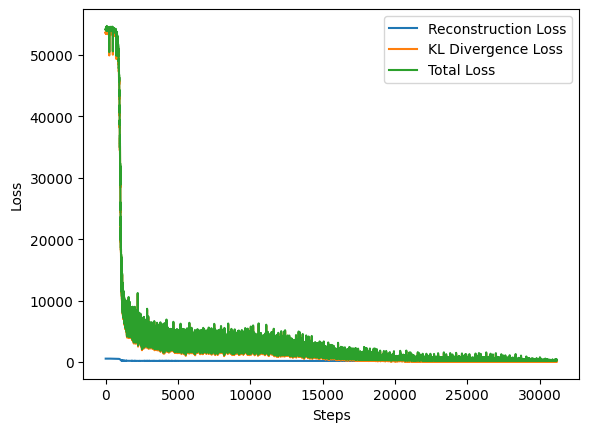

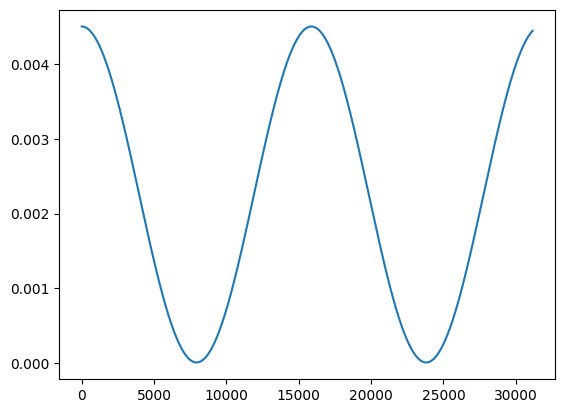

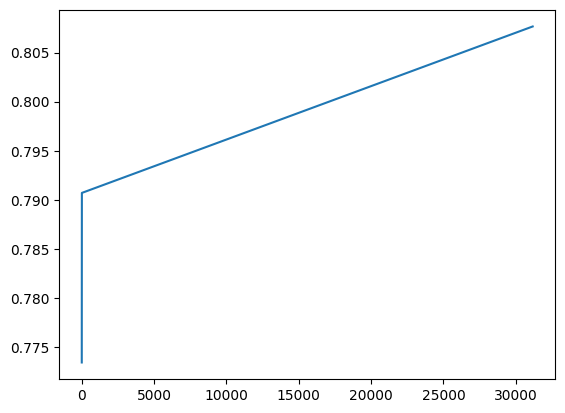

[I 2023-08-05 17:03:41,141] Trial 13 finished with value: 270.0715637207031 and parameters: {'hidden_dim_1': 287, 'hidden_dim_2': 52, 'batch_size': 242, 'epochs': 128, 'initial_lr': 0.004499350007600813, 'temperature': 0.7734326460752352, 'final_temperature': 0.7907014755926781, 'beta': 96.10762428987641}. Best is trial 10 with value: 170.5261688232422.


Finished trail 13/100 | Final loss: 270.0715637207031


Epoch: 2/64 | Re.Loss: 545.3832397, KL.Loss: 57115.2109375 | Lr: 0.0021365 Temp: 1.4009436:   3%|▎         | 320/10240 [00:15<07:52, 20.97it/s]STAGE:2023-08-05 17:03:59 29615:1610375 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
Epoch: 5/64 | Re.Loss: 545.3377686, KL.Loss: 57003.1054688 | Lr: 0.0017301 Temp: 1.3687502:   8%|▊         | 800/10240 [00:59<13:43, 11.46it/s]

: 

: 

In [6]:
# 超参数调优
import optuna

current_trial = 0

# 记录文件名
log_file = 'trials_log.txt'

def objective(trial):
    torch.cuda.empty_cache()
    global current_trial
    dataset_name = 'MNIST'
    hidden_dim_1 = trial.suggest_int('hidden_dim_1', 128, 512)
    hidden_dim_2 = trial.suggest_int('hidden_dim_2', 32, 128)
    batch_size = trial.suggest_int('batch_size', 16, 1024)
    epochs = trial.suggest_int('epochs', 32, 128)
    initial_lr = trial.suggest_float('initial_lr', 1e-4, 1e-2, log=True)
    temperature = trial.suggest_float('temperature', 0.5, 2.0)
    final_temperature = trial.suggest_float('final_temperature', 0.1, 1.0)
    beta = trial.suggest_float('beta', 0.01, 100.0)
    
    dataset, encoder, decoder, final_loss = train_and_plot(dataset_name, hidden_dim_1, hidden_dim_2, batch_size, epochs, initial_lr, temperature, final_temperature, beta)
    
    print(f'Finished trail {current_trial}/100 | Final loss: {final_loss}')
    current_trial += 1
    
    # 记录参数和结果
    with open(log_file, 'a') as f:
        f.write(f'Trial {current_trial}: \n')
        f.write(f'    Hidden Dim 1: {hidden_dim_1}\n')
        f.write(f'    Hidden Dim 2: {hidden_dim_2}\n')
        f.write(f'    Batch Size: {batch_size}\n')
        f.write(f'    Epochs: {epochs}\n')
        f.write(f'    Initial LR: {initial_lr}\n')
        f.write(f'    Temperature: {temperature}\n')
        f.write(f'    Final Temperature: {final_temperature}\n')
        f.write(f'    Beta: {beta}\n')
        f.write(f'    Final Loss: {final_loss}\n')
        f.write('-' * 50 + '\n')
    
    return final_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('Value: ', trial.value)
print('Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')


In [ ]:
dataset_name = 'MNIST'
hidden_dim_1 = 512
hidden_dim_2 = 256
batch_size = 32
epochs = 4
initial_lr = 1e-3
temperature = 1.0
final_temperature = 0.3

dataset, encoder, decoder, final_loss = train_and_plot(dataset_name, hidden_dim_1, hidden_dim_2, batch_size, epochs, initial_lr, temperature, final_temperature)

In [ ]:
sample_and_reconstruct(dataset, encoder, decoder, input_dim=28*28, num_classes=10, temperature=0.5)

In [ ]:
categorical_dim = 10
input_dim = 28 * 28
temperature = 0.5
generate_from_latent(dataset, encoder, decoder, categorical_dim=10, temperature=0.5)

In [ ]:
visualize_latent(dataset_name, encoder, num_classes=10, temperature=0.5)